### Training of Hyper-MORL
The **script** folder contains all training scripts. For example, you can run our algorithm on MO-Walker2d for nine runs:
```
python scripts/walker.py --num-seeds 9
```
After the training, the results are saved in **/results/[env_name]/Hyper-MORL/default/[run_id]** by default. In the **final** subfolder, **policy.py** contains the trained hyperent and **normalization.pkl** contains information for reward normalization and observation normalization during training.  
For your convenience, we have provided pretrained models for all problems (in the **pretrained** folder). you can run the following code to view the summarized results.

In [165]:
import numpy as np
import os
from texttable import Texttable
env_names = ["MO-Swimmer-v2", "MO-HalfCheetah-v2", "MO-Walker2d-v2","MO-Ant-v2","MO-Hopper-v2","MO-Humanoid-v2", "MO-Hopper-v3"]
dir_name = os.path.dirname(os.path.dirname(os.path.abspath("__file__"))) + "/pretrained"
num_runs = 9
hvs = np.zeros((len(env_names), num_runs))
for i, env_name in enumerate(env_names):
    for r in range(num_runs):
        with open(dir_name + "/" + env_name + "/Hyper-MORL/default/" + str(r) + "/final/objs.txt") as f:
            hv = float(f.readline().split('=')[1])
            hvs[i][r] = hv

table = Texttable()
table.set_cols_align(["l", 'c', 'c', 'c', 'c'])
table.set_cols_valign(["c", 'c', 'c', 'c', 'c'])
table.set_cols_dtype(['t', 't', 't', 't', 't'])
table_data = []
table_data.append(['Env. name', 'HV Mean', 'HV Std',  'HV Median (run id)', 'HV Max (run id)'])
for i, env_name in enumerate(env_names):
    table_data.append([])
    table_data[-1].append(env_name)
    table_data[-1].append('%.3e'% (np.mean(hvs[i, :])))
    table_data[-1].append('%.3e'% (np.std(hvs[i, :])))
    table_data[-1].append('%.2e (%d)'% (np.median(hvs[i, :]), np.where(hvs[i, :] == np.median(hvs[i, :]))[0][0]))
    table_data[-1].append('%.2e (%d)'% (np.max(hvs[i, :]), np.where(hvs[i, :] == np.max(hvs[i, :]))[0][0]))
table.add_rows(table_data)

print(table.draw())


+------------------+-----------+-----------+-----------------+-----------------+
|    Env. name     |  HV Mean  |  HV Std   | HV Median (run  | HV Max (run id) |
|                  |           |           |       id)       |                 |
+==================+===========+===========+=================+=================+
| MO-Swimmer-v2    | 2.883e+04 | 4.360e+03 |  3.07e+04 (4)   |  3.19e+04 (0)   |
+------------------+-----------+-----------+-----------------+-----------------+
| MO-              | 5.533e+06 | 1.016e+05 |  5.53e+06 (0)   |  5.65e+06 (5)   |
| HalfCheetah-v2   |           |           |                 |                 |
+------------------+-----------+-----------+-----------------+-----------------+
| MO-Walker2d-v2   | 5.368e+06 | 3.466e+05 |  5.44e+06 (1)   |  5.87e+06 (8)   |
+------------------+-----------+-----------+-----------------+-----------------+
| MO-Ant-v2        | 7.490e+06 | 1.604e+05 |  7.53e+06 (0)   |  7.70e+06 (2)   |
+------------------+--------

### Policy Sampling From the Trained Hypernet
After a hypernet is trained, you can input an arbitrary preference to obtain the optimal policy parameters corresponding to the given preference. For example, you can input 2,000 uniformly sampled preferences to the hyperent trained on MO-Walker2d one by one, and obtain 2,000 different groups of policy parameters:
```
python/visualization/test_hypermorl.py --env-name MO-Walker2d-v2
```  
The input preferences, output policy parameters and evaluated objective values are saved in **/results/sample** by default.  


### Visualization
#### Preference Space & Objective Space

We provide an script to visualize the relation between the input preference and the objective values of the corresponding output policy. 
```
python visualization/pref_obj.py
```
After execute the above command, you will see an interactive figure. In the figure, you can adjust the input preference by drag the point in the preference space. Moreover, you can also visualize the behavior of the output policy by clicking the button.

#### Preference Space & Parameter Space & Objective Space

float32 [[ 0.1182198   0.04562458 -0.12374537 ... -3.3737404  -2.9601038
  -2.821393  ]
 [ 0.11555679  0.04969007 -0.12460546 ... -3.3801503  -2.969549
  -2.8307247 ]
 [ 0.11473407  0.05094607 -0.12487117 ... -3.3821304  -2.972467
  -2.8336072 ]
 ...
 [ 0.06918605  0.13602239 -0.13593103 ... -3.2804184  -2.9545233
  -2.81747   ]
 [ 0.06721561  0.14082125 -0.13613096 ... -3.261476   -2.9414084
  -2.8048263 ]
 [ 0.06699757  0.14136317 -0.13615036 ... -3.2592459  -2.9398441
  -2.803318  ]]
T-SNE: seed = 0
T-SNE: seed = 1
T-SNE: seed = 2
T-SNE: seed = 3
T-SNE: seed = 4
T-SNE: seed = 5
T-SNE: seed = 6
T-SNE: seed = 7
T-SNE: seed = 8
T-SNE: seed = 9


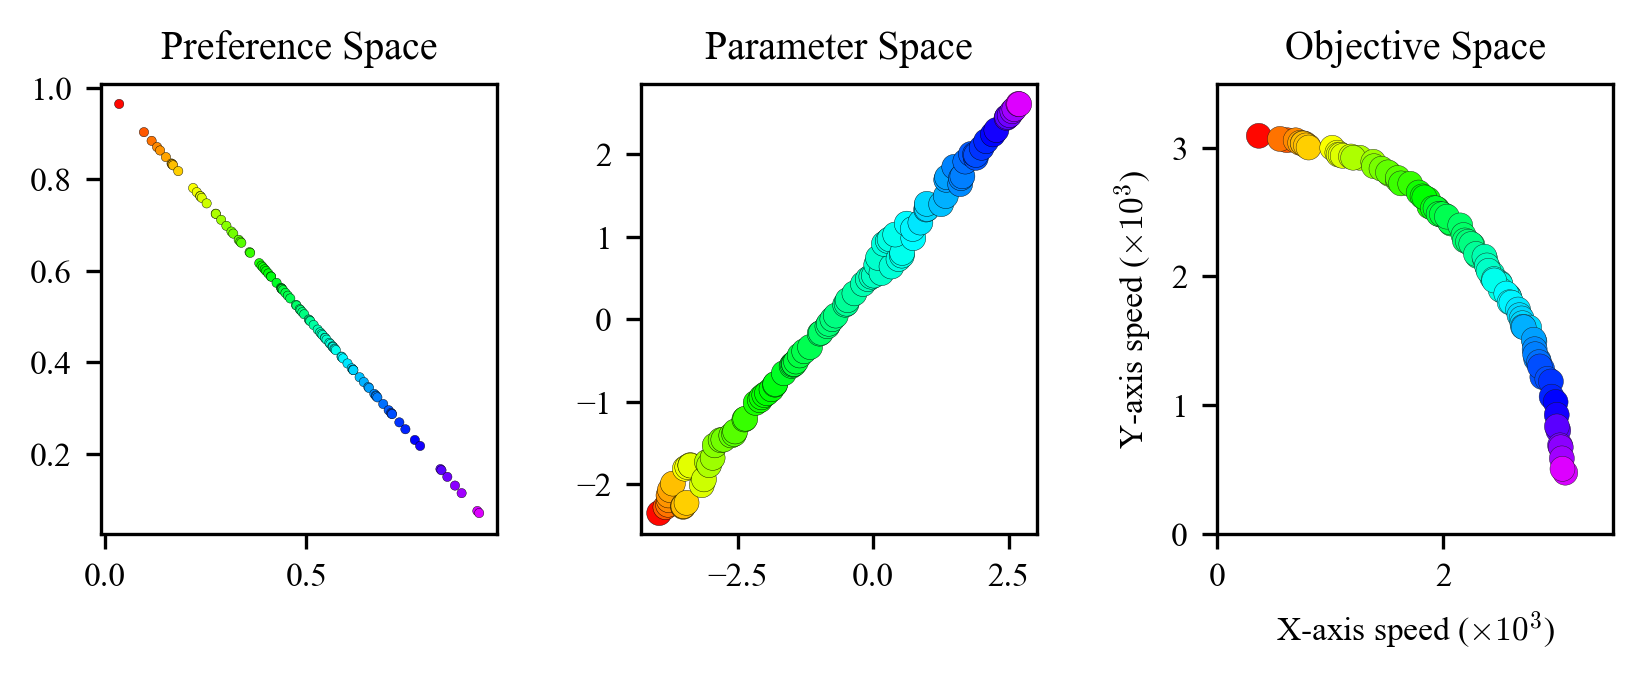

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os, sys
import torch
from objective_space import draw_objectives

def ConvertData(X):
    results = []
    kl_values = []
    num_runs = 10
    X = X.astype(np.float32) 
    print(X.dtype, X)
    for seed in range(num_runs):
        print("T-SNE: seed =", seed)
        np.random.seed(seed)
        tsne = TSNE(n_components=2, random_state=seed,perplexity=50)
        X_tsne = tsne.fit_transform(X)
        results.append(X_tsne)
        kl_values.append(tsne.kl_divergence_)
    result = results[np.argmin(np.array(kl_values))]  
    
    return result

def draw_objectives(ax, objs, colors, env_name):
    # Settings
    if objs.shape[1] == 3:
        draw_3objectives(ax, objs, colors)
        return
    env_name_hyper = ["MO-Swimmer-v2", "MO-HalfCheetah-v2", "MO-Walker2d-v2","MO-Ant-v2","MO-Hopper-v2","MO-Humanoid-v2"]
    xlabel = ["Forward speed", "Forward speed","Forward speed","X-axis speed", "Forward speed","Forward speed"]
    ylabel = ["Energy efficiency","Energy efficiency","Energy efficiency", "Y-axis speed","Jumping height","Energy efficiency"]
    xscale = [2,3,3,3,3,4]
    yscale = [2,3,3,3,3,4]
    xvals = [300,3000,3000,3500,4500,10000]
    yvals = [200,3000,3000,3500,6000,10000]
    #ax.set_position(pos=[0.15,0.15,0.81,0.82])
    i = env_name_hyper.index(env_name)

    ax.scatter(objs[:, 0]/(10**xscale[i]), objs[:, 1]/(10**yscale[i]),s=10, marker='o', linewidths=0.1, facecolors=colors, edgecolors=(0.1,0.1,0.1))

    s1 = " ($\\times$$10^{%d}$)"%(xscale[i])
    s2 = " ($\\times$$10^{%d}$)"%(yscale[i])
    ax.set_xlabel(xlabel[i]+r"%s"%(s1))
    ax.set_ylabel(ylabel[i]+r"%s"%(s2))
    ax.set_xlim([0, xvals[i]/(10**xscale[i])])
    ax.set_ylim([0, yvals[i]/(10**yscale[i])])


dir_name = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
# ["MO-Swimmer-v2", "MO-HalfCheetah-v2","MO-Walker2d-v2", "MO-Ant-v2", "MO-Hopper-v2","MO-Humanoid-v2","MO-Hopper-v3"]
env_name = "MO-Ant-v2"
run_id = 0
draw_nondominated = True
obj_num = 3 if env_name == "MO-Hopper-v3" else 2
pref_num = 2000 if obj_num == 2 else 20100

#ax.set_position(pos=[0.24,0.19,0.7,0.75])
params = np.load("%s/visualization/sample/%s_params_n%d_%d.npz"%(dir_name, env_name, pref_num, run_id))['params']
prefs = np.load("%s/visualization/sample/%s_prefs_n%d.npz"%(dir_name, env_name, pref_num))['prefs']
objs = np.load("%s/visualization/sample/%s_objs_n%d_%d.npz"%(dir_name, env_name, pref_num, run_id))['objs']
flag = np.load("%s/visualization/sample/%s_objs_n%d_%d.npz"%(dir_name, env_name, pref_num, run_id))['flag']

# points are marked with different color based on its corresponding preference
colors = [] 
if obj_num==3:
    k = 8
    for i in range(len(objs)):
        colors.append(np.clip(prefs[i]/np.sum(prefs[i]**k)**(1/k), 0, 1))        
else:
    colors = []
    hsv = matplotlib.colormaps['gist_rainbow']
    for i in range(len(objs)):
            colors.append(hsv(i / len(prefs)))   
colors = np.array(colors)
if draw_nondominated:
    prefs = prefs[flag==1]
    objs = objs[flag==1]
    colors = colors[flag==1]
    params = params[flag==1]

# To visual the sampled policy parameters, we use T-SNE to embed them from high-dimensional space to low-dimensional space
params = ConvertData(params)

font = {'family' : 'Times New Roman',
'size'   : 8}
matplotlib.rc('font', **font)
plt.rcParams['mathtext.fontset']='cm'
fig = plt.figure(figsize=(6,2), dpi=300)

obj_ax = plt.subplot(1,3,3)
pref_ax = plt.subplot(1,3,1)
param_ax = plt.subplot(1,3,2)

pref_ax.set_position([0.1, 0.15, 0.22, 0.75])
pref_ax.set_title('Preference Space')

param_ax.set_position([0.4, 0.15, 0.22, 0.75])
param_ax.set_title('Parameter Space')

obj_ax.set_position([0.72, 0.15, 0.22, 0.75])
obj_ax.set_title('Objective Space')

pref_ax.scatter(prefs[:, 0], prefs[:, 1], s=10, marker='o', linewidths=0.1, c=colors, edgecolors='black',zorder=2)

param_ax.scatter(params[:, 0], params[:, 1], s=10,marker='o', linewidths=0.1, c=colors, edgecolors='black',zorder=2)
#obj_ax.scatter(params[:, 0], params[:, 1],marker='o', linewidths=0.1, c=colors, edgecolors='black',zorder=2)
draw_objectives(obj_ax, objs, colors, env_name)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os, sys
import torch

def ConvertData(X):
    results = []
    kl_values = []
    num_runs = 10
    for seed in range(num_runs):
        print("T-SNE: seed =", seed)
        np.random.seed(seed)
        tsne = TSNE(n_components=2, random_state=seed,perplexity=50)
        X_tsne = tsne.fit_transform(X)
        results.append(X_tsne)
        kl_values.append(tsne.kl_divergence_)
    result = results[np.argmin(np.array(kl_values))]    
    return result

def draw_objectives(ax, objs, colors):
    ax.set_xlabel(r"Forward speed (%s)"%("$\\times 10^3$"))
    ax.set_ylabel(r"Jumping height (%s)"%("$\\times 10^3$"))
    ax.set_zlabel(r"Energy efficiency (%s)"%("$\\times 10^3$"))
    label_pad = 0
    ax.xaxis.labelpad=label_pad
    ax.yaxis.labelpad=label_pad
    ax.zaxis.labelpad=label_pad
    ax.xaxis.tickpad=0
    ax.view_init(elev=25, azim=28)
    #ax.scatter(objs[:,0]/1000, objs[:,1]/1000, objs[:,2]/1000,s=10, marker='o', linewidths=0.2, c=np.clip(colors,0,1), edgecolors='black')
    ax.set_xlim([0,3200/1000])
    ax.set_ylim([0,6000/1000])
    ax.set_zlim([0,3000/1000])

dir_name = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
env_name = "MO-Hopper-v3"
run_id = 6
draw_nondominated = True
obj_num = 3
pref_num = 20100

params = np.load("%s/visualization/sample/%s_params_n%d_%d.npz"%(dir_name, env_name, pref_num, run_id))['params']
prefs = np.load("%s/visualization/sample/%s_prefs_n%d.npz"%(dir_name, env_name, pref_num))['prefs']
objs = np.load("%s/visualization/sample/%s_objs_n%d_%d.npz"%(dir_name, env_name, pref_num, run_id))['objs']
flag = np.load("%s/visualization/sample/%s_objs_n%d_%d.npz"%(dir_name, env_name, pref_num, run_id))['flag']

# points are marked with different color based on its corresponding preference
colors = [] 
k = 8
for i in range(len(objs)):
    colors.append(np.clip(prefs[i]/np.sum(prefs[i]**k)**(1/k), 0, 1))        
 
colors = np.array(colors)
if draw_nondominated:
    prefs = prefs[flag==1]
    objs = objs[flag==1]
    colors = colors[flag==1]
    params = params[flag==1]

# To visual the sampled policy parameters, we use T-SNE to embed them from high-dimensional space to low-dimensional space
params = ConvertData(params)




T-SNE: seed = 0


KeyboardInterrupt: 

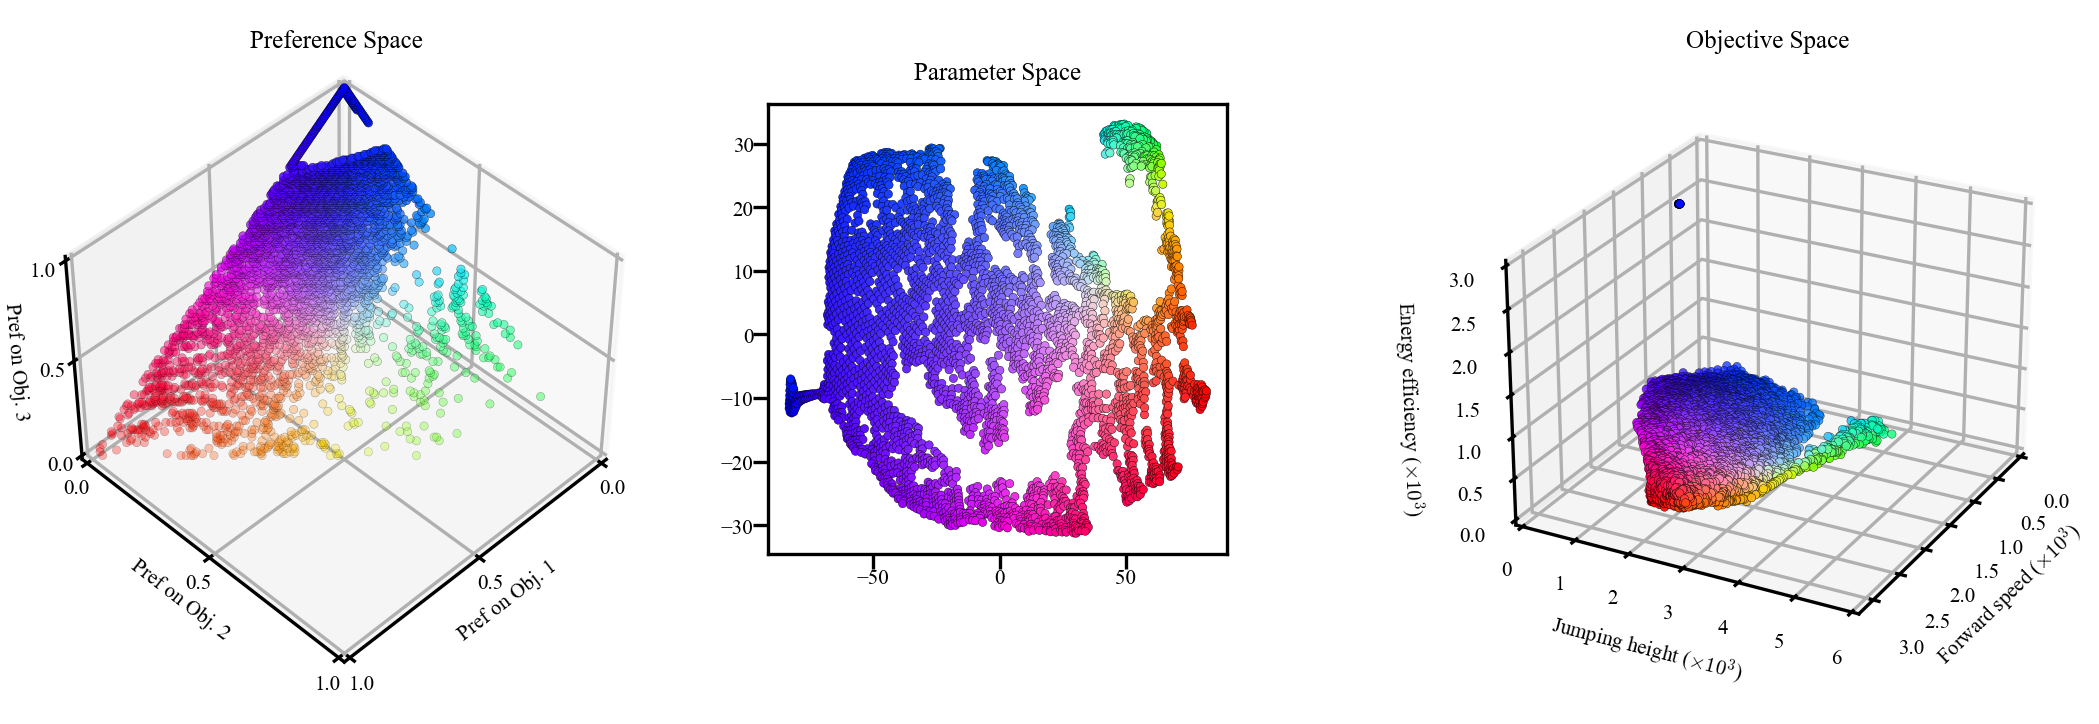

In [ ]:
def draw_objectives(ax, objs, colors):
    ax.set_xlabel(r"Forward speed (%s)"%("$\\times 10^3$"))
    ax.set_ylabel(r"Jumping height (%s)"%("$\\times 10^3$"))
    ax.set_zlabel(r"Energy efficiency (%s)"%("$\\times 10^3$"))
    label_pad = -7
    ax.xaxis.labelpad=label_pad
    ax.yaxis.labelpad=label_pad
    ax.zaxis.labelpad=label_pad

    ax.tick_params(axis='both', which='major', pad=-2)
    ax.xaxis.set_tick_params(pad=0)
    #ax.xaxis.get_tick_padding=0
    ax.view_init(elev=25, azim=28)
    ax.scatter(objs[:,0]/1000, objs[:,1]/1000, objs[:,2]/1000,s=4, marker='o', linewidths=0.1, c=np.clip(colors,0,1), edgecolors='black')
    ax.set_xlim([0,3200/1000])
    ax.set_ylim([0,6000/1000])
    ax.set_zlim([0,3000/1000])

font = {'family' : 'Times New Roman',
'size'   : 5}
matplotlib.rc('font', **font)
plt.rcParams['mathtext.fontset']='cm'
fig = plt.figure(figsize=(9,3), dpi=300)
matplotlib.rcParams['xtick.major.pad']='0'
matplotlib.rcParams['ytick.major.pad']='0'


pref_ax = plt.subplot(1,3,1, projection='3d')
param_ax = plt.subplot(1,3,2)
obj_ax = plt.subplot(1,3,3, projection='3d')
pref_ax.tick_params(axis='both', which='major', pad=-2)

pref_ax.set_position([0.1, 0.15, 0.22, 0.75])
pref_ax.set_title('Preference Space')
pref_ax.set_xlim([0,1])
pref_ax.set_ylim([0,1])
pref_ax.set_zlim([0,1])
pref_ax.tick_params(axis='both', which='major', pad=-5)
pref_ax.xaxis.set_ticks([0, 0.5, 1])
pref_ax.yaxis.set_ticks([0, 0.5, 1])
pref_ax.zaxis.set_ticks([0, 0.5, 1])
pref_ax.set_xlabel("Pref on Obj. 1")
pref_ax.set_ylabel("Pref on Obj. 2")
pref_ax.set_zlabel("Pref on Obj. 3")
label_pad = -13
pref_ax.xaxis.labelpad=label_pad
pref_ax.yaxis.labelpad=label_pad
pref_ax.zaxis.labelpad=label_pad

param_ax.set_position([0.37, 0.32, 0.17, 0.50])
param_ax.set_title('Parameter Space')

obj_ax.set_position([0.63, 0.15, 0.22, 0.75])
obj_ax.set_title('Objective Space')


pref_ax.scatter(prefs[:, 0], prefs[:, 1], prefs[:, 2], s=4, marker='o', linewidths=0.1, c=colors, edgecolors='black',zorder=2)
pref_ax.view_init(elev=45, azim=45)
param_ax.scatter(params[:, 0], params[:, 1],marker='o', s=4, linewidths=0.1, c=colors, edgecolors='black',zorder=2)
draw_objectives(obj_ax, objs, colors)
plt.show()